Reduce multi-dimensional dataset color each images target class

In [0]:
# Python 2 and 3 support
from __future__ import unicode_literals, print_function, division

# Common Imports
import numpy as np
import os
import time

# ML Imports
from sklearn.datasets import fetch_mldata
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Graph Imports
%matplotlib inline
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [0]:
# Config
PROJECT_ROOT_DIR = '.'

# Declare Functions


def image_path(fig_id):
    if not os.path.exists('images'):
        os.makedirs('images')
    return os.path.join(PROJECT_ROOT_DIR, 'images', fig_id)


def save_fig(fig_id, tight_layout=True):
    print("Saving", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)


def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Scale the input features for range 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Create the list of coordinates of the digits plotted
    # Create one initially
    neighbors = np.array([[10., 10.]])
    plt.figure(figsize=figsize)
    cmap = matplotlib.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(
            X_normalized[y == digit, 0],
            X_normalized[y == digit, 1],
            c=cmap(digit / 9))
    plt.axis("off")
    ax = plt.gcf().gca()
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(
            np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(
                    image_coord[0],
                    image_coord[1],
                    str(int(y[index])),
                    color=cmap(y[index] / 9),
                    fontdict={
                        "weight": "bold",
                        "size": 16
                    })
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(
                    OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

Get and subset the data to reduce processing time

In [0]:
# Get Data
mnist = fetch_mldata('MNIST original')

# Set seed value for reproducability
np.random.seed(42)

# Subset Dataset
m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

Try reducing the dataset dimensionality with t-SNE

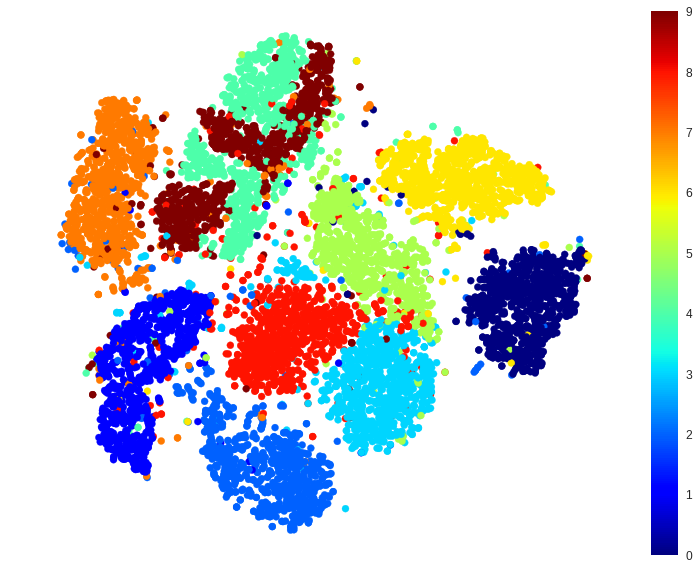

In [4]:
# Reduce with tsne
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

# Create Scatterplot
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()

Digits classified as grouping in differeing colors, note overlapping digits

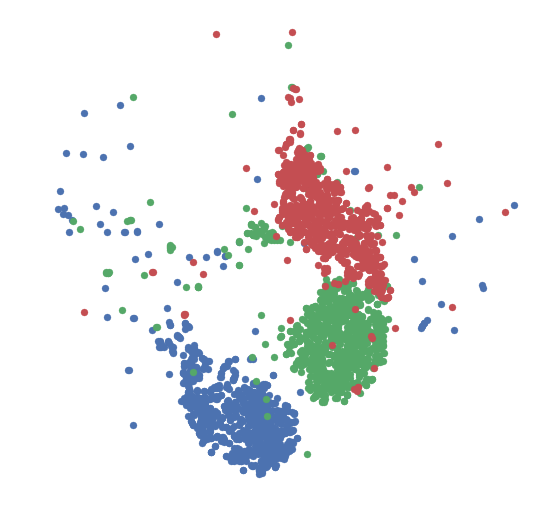

In [5]:
# Seperate 2, 3, and 5
plt.figure(figsize=(9, 9))
cmap = matplotlib.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(
        X_reduced[y == digit, 0],
        X_reduced[y == digit, 1],
        cmap=cmap(digit / 9))
plt.axis('off')
plt.show()

2, 3, 5 wth still some overlap

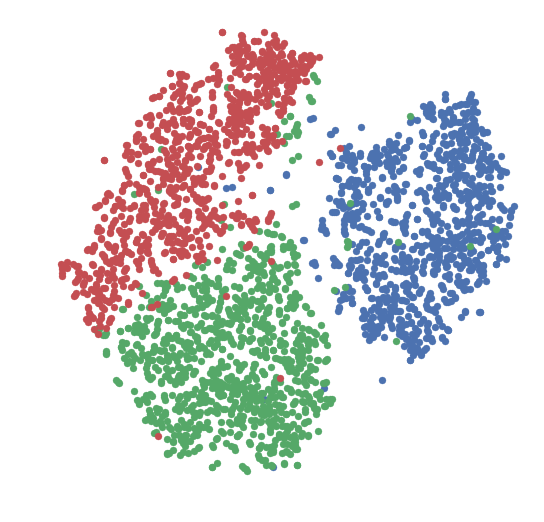

In [6]:
idx = (y == 2) | (y == 3) | (y == 5)
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

plt.figure(figsize=(9, 9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0],
                X_subset_reduced[y_subset == digit, 1])
plt.axis('off')
plt.show()

Using t_SNE on the subset reduces some more overlap

Saving digit_images


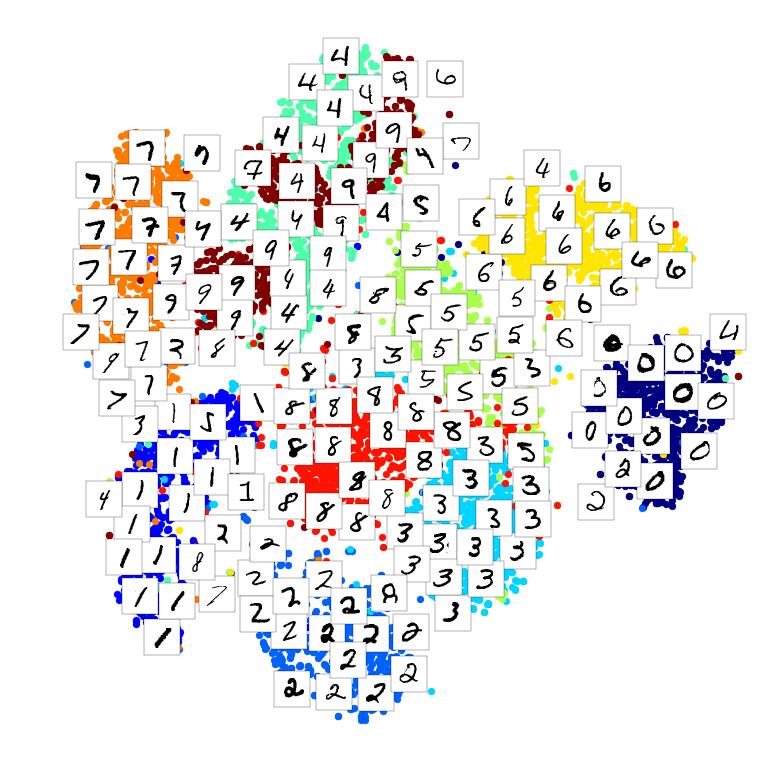

In [18]:
plot_digits(X_reduced, y, images=X, figsize=(11,11))
save_fig('digit_images')
plt.show()

Visualizaing the digits on the clusters helps distinguish where errors are

Saving 2_3_5_digits


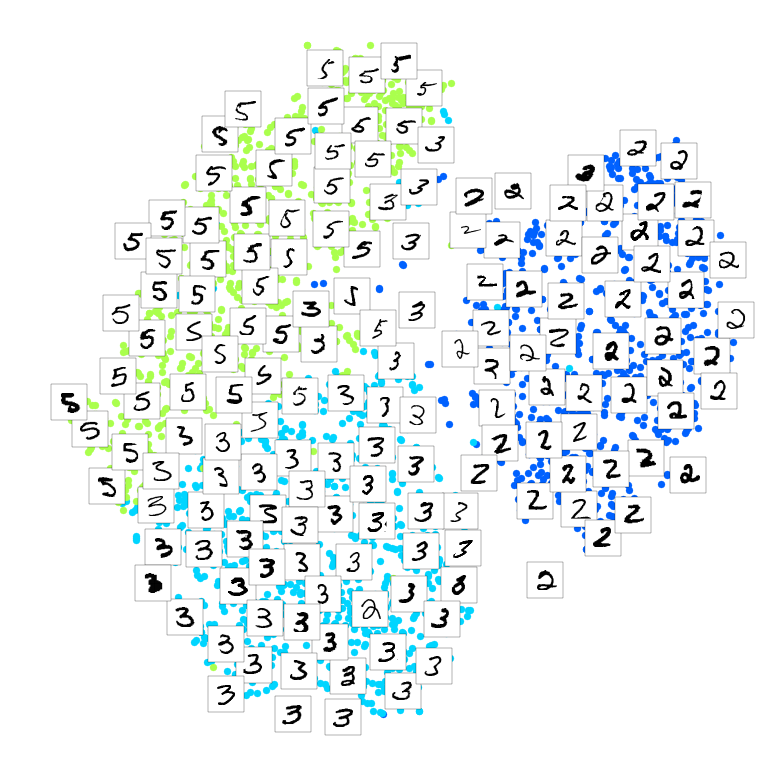

In [8]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(11,11))
save_fig('2_3_5_digits')
plt.show()

Notice some overlapping of 3s and 5s
Let's try with various combinations of dimensionality reduction

PCA Took 0.68s


<function matplotlib.pyplot.show>

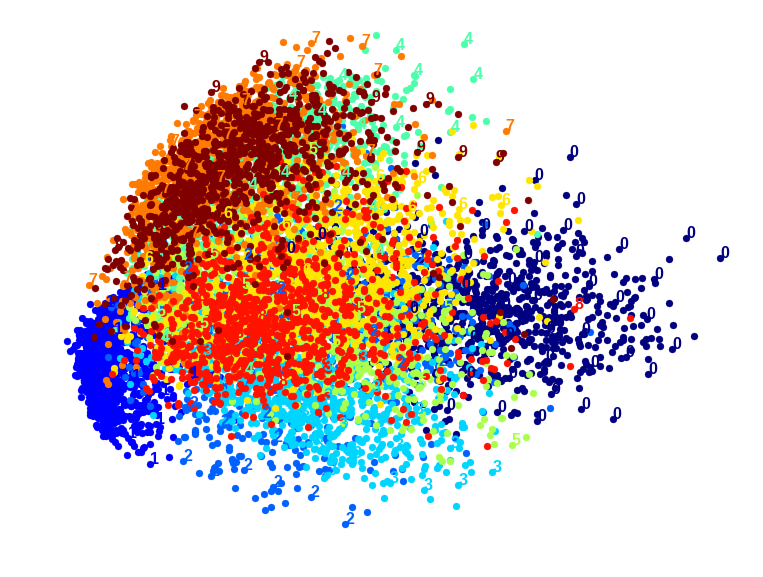

In [9]:
# PCA
t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA Took {:.2f}s".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show

LLE took 217.6s


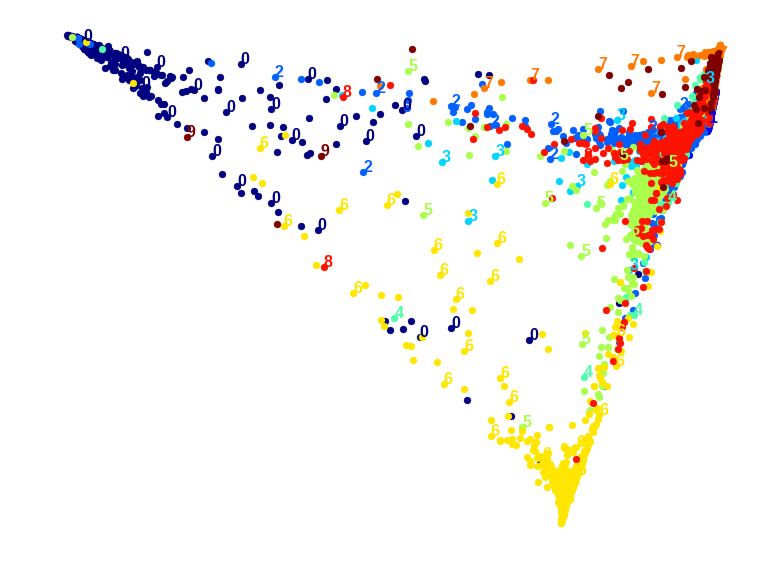

In [10]:
# LLE
t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(
    n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE took {:.1f}s".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

PCA+LLE took 58.8s


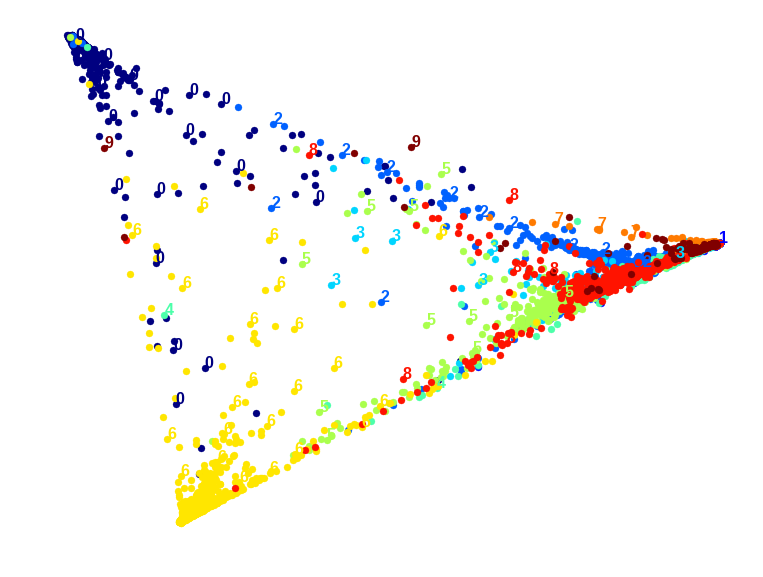

In [11]:
# PCA and LLE
pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE took {:.1f}s".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

MDS took 185.1s on 2000 MNIST images instead of 10000


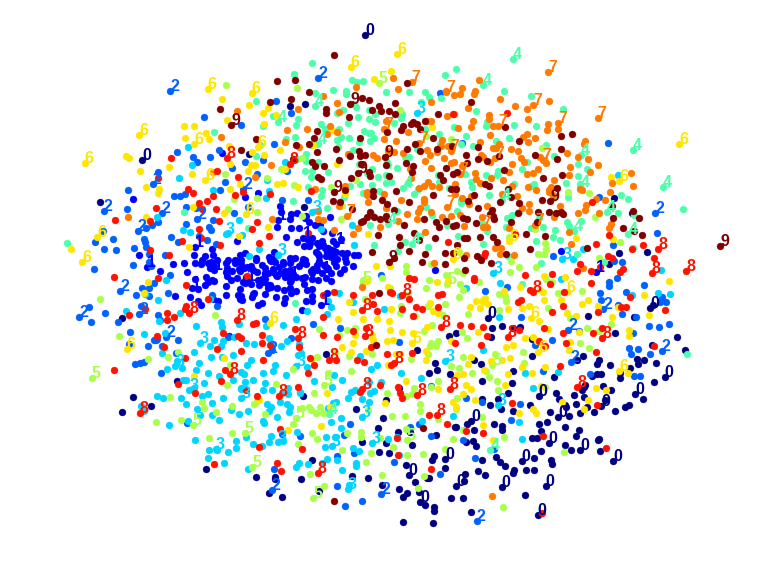

In [12]:
# MDS
m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS took {:.1f}s on 2000 MNIST images instead of 10000".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

PCA+MDS took 185.1s on 2000 MNIST images


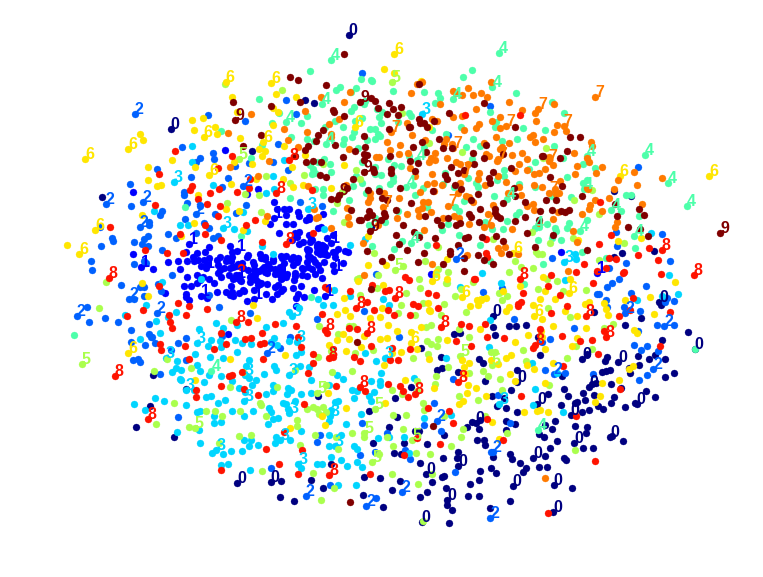

In [13]:
# PCA+MDS
pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS took {:.1f}s on 2000 MNIST images".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA took 2.6s


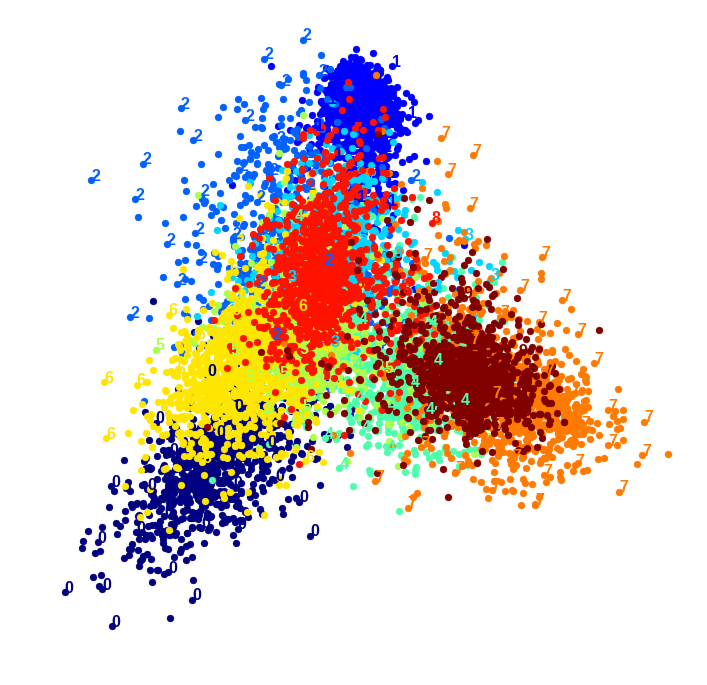

In [14]:
# LDA
t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA took {:.1f}s".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12, 12))
plt.show()

t-SNE took 467.5s


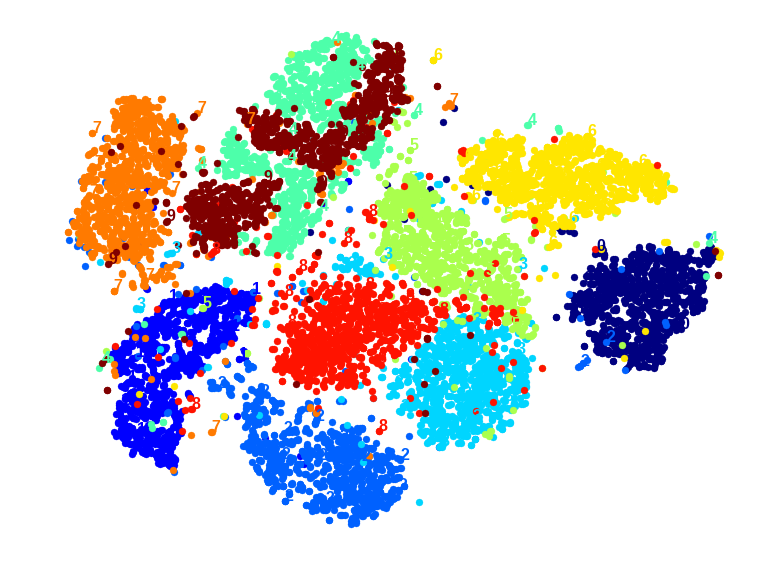

In [15]:
# TSNE timed
t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE took {:.1f}s".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

PCA+t-SNE took 318.7s


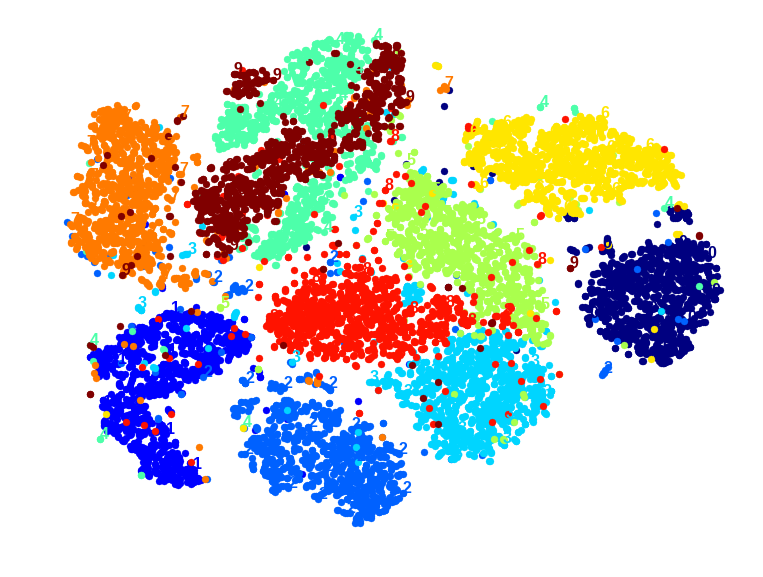

In [16]:
# PCA + TSNE
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

PCA Took 1.39s

LLE took 448.0s

PCA+LLE took 175.3s

MDS took 345.5s on 2000 MNIST images instead of 10000

PCA+MDS took 299.8s on 2000 MNIST images

LDA took 15.8s

t-SNE took 1169.8s

PCA+t-SNE took 777.7s

*In all PCA and t-SNE did a pretty job in a good time frame *